## 1. Model Defnition

In [1]:
import torch
import torch.nn as nn
from utils_ismir import MusdbLoaer
from intermediate_layers import TFC_TDF
from frameworks import U_Net_Framework

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
musdb_loader = MusdbLoaer(device=device)

def mk_tfc_tdf (input_c, output_c, f, i):
    print('intermediate\t at level', i, 'with TFC_TDF')
    return TFC_TDF(in_channels=input_c, num_layers=5, gr=output_c, kt=3, kf=3, f=f, bn_factor=16, bias=True)

t_scale = [0,2,4,6]

def mk_tfc_tdf_ds (i, f, t_scale=t_scale):
    scale = (2,2) if i in t_scale else (1,2)
    print('downsampling\t at level', i, 'with scale(T, F): ', scale, ', F_scale: ', f, '->', f//scale[-1])
    ds = nn.Sequential(
        nn.Conv2d(in_channels=24, out_channels=24, kernel_size=scale, stride=scale),
        nn.BatchNorm2d(24)
    )
    return ds, f//scale[-1]

def mk_tfc_tdf_us (i, f, n, t_scale=t_scale):
    scale = (2,2) if i in [n -1 -s for s in  t_scale] else (1,2)

    print('upsampling\t at level', i, 'with scale(T, F): ', scale, ', F_scale: ', f, '->', f*scale[-1])
    us = nn.Sequential(
        nn.ConvTranspose2d(in_channels=24, out_channels=24, kernel_size=scale, stride=scale),
        nn.BatchNorm2d(24)
    )
    return us, f*scale[-1]


model = U_Net_Framework(
    musdb_loader, est_mode='cac_mapping', internal_channels=24, num_blocks=17, 
    mk_block_f=mk_tfc_tdf, mk_ds_f=mk_tfc_tdf_ds, mk_us_f=mk_tfc_tdf_us
).cuda()

intermediate	 at level 0 with TFC_TDF
downsampling	 at level 0 with scale(T, F):  (2, 2) , F_scale:  1024 -> 512
intermediate	 at level 1 with TFC_TDF
downsampling	 at level 1 with scale(T, F):  (1, 2) , F_scale:  512 -> 256
intermediate	 at level 2 with TFC_TDF
downsampling	 at level 2 with scale(T, F):  (2, 2) , F_scale:  256 -> 128
intermediate	 at level 3 with TFC_TDF
downsampling	 at level 3 with scale(T, F):  (1, 2) , F_scale:  128 -> 64
intermediate	 at level 4 with TFC_TDF
downsampling	 at level 4 with scale(T, F):  (2, 2) , F_scale:  64 -> 32
intermediate	 at level 5 with TFC_TDF
downsampling	 at level 5 with scale(T, F):  (1, 2) , F_scale:  32 -> 16
intermediate	 at level 6 with TFC_TDF
downsampling	 at level 6 with scale(T, F):  (2, 2) , F_scale:  16 -> 8
intermediate	 at level 7 with TFC_TDF
downsampling	 at level 7 with scale(T, F):  (1, 2) , F_scale:  8 -> 4
intermediate	 at level 7 with TFC_TDF
upsampling	 at level 0 with scale(T, F):  (1, 2) , F_scale:  4 -> 8
intermedi

In [3]:
print('# params:', sum(p.numel() for p in model.parameters() if p.requires_grad) )

# params: 1930840


## 2. Load Pretrained Model

In [4]:
!ls pretrained | grep cac_tfc_tdf_17_vocals

cac_tfc_tdf_17_vocals_top1.pt
cac_tfc_tdf_17_vocals_top2.pt
cac_tfc_tdf_17_vocals_top3.pt


In [5]:
pretrained_paths = ['pretrained/cac_tfc_tdf_17_vocals_top1.pt',
                    'pretrained/cac_tfc_tdf_17_vocals_top2.pt',
                    'pretrained/cac_tfc_tdf_17_vocals_top3.pt']

pretrained_params = torch.load(pretrained_paths[0])
model.load_state_dict(pretrained_params)

<All keys matched successfully>

## 3. Evaluation: Musdb18 Benchmark

### 3.1 SDR performance of the pretrained U-Net with 17 TFC_TDF blocks

7.231349508046177


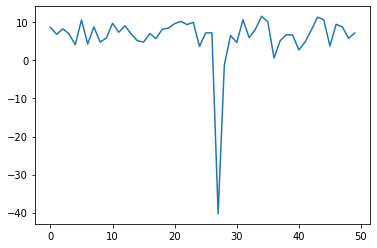

SDR mean: 6.1756639535808375
SDR median: 7.14880312538662
mean of SDR medians:  7.122239125735944


In [4]:
from utils_ismir import separate, eval_testset
import statistics as stats

sdr_medians = []

for pretrained in pretrained_paths:
    
    pretrained_params = torch.load(pretrained)
    model.load_state_dict(pretrained_params)
    
    def separator (mix):
        return separate(musdb_loader, model, mix, batch_size=16)

    sdrs, sdr_mean, sdr_median  = eval_testset(musdb_loader, separator, target_name='vocals')
    sdr_medians.append(sdr_median)
    
print('mean of SDR medians: ', stats.mean(sdr_medians))

### 3.2. SDR performance of the pretrained UMX

In [5]:
# !git clone https://github.com/sigsep/open-unmix-pytorch
# %mv open-unmix-pytorch/test.py open-unmix-pytorch/umx_test.py
# !pip install norbert

6.334033248512589


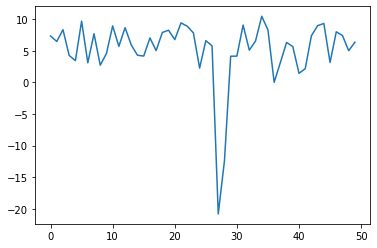

SDR mean: 5.184140683089768
SDR median: 6.319676771911556
UMX's SDR medians:  6.319676771911556


In [22]:
%cd open-unmix-pytorch
import umx_test as umx

musdb_loader = MusdbLoaer(musdb_path='../data/musdb18/', device=device)

def separator(mix):
    
    est = umx.separate(
        audio=mix.T,
        targets=['vocals', 'drums', 'bass', 'other'], 
        device=device
    )
    
    return est['vocals'].T

umx_sdrs, umx_sdr_mean, umx_sdr_median  = eval_testset(musdb_loader, separator, target_name='vocals')

    
print('UMX\'s SDR medians: ', umx_sdr_median)

In [13]:
print('# params:', sum(p.numel() for p in umx.load_model('vocals', ).parameters() if p.requires_grad) )

# params: 8893348
